In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Black-Scholes formula for put option price and delta
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    delta = norm.cdf(d1) - 1  # Delta of a put option
    return put_price, delta

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  # Delta of a call option
    return call_price, delta

# Simulate stock price paths using Geometric Brownian Motion
def simulate_gbm(S0, T, r, sigma, dt, steps):
    mu = r
    S = np.zeros(steps + 1)
    S[0] = S0
    for t in range(1, steps + 1):
        S[t] = S[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.randn())
    return S

In [3]:
def delta_hedging(S0, K, T, r, sigma, N_options, rebalancing_interval, op):
    dt = rebalancing_interval / 52  # Convert weeks to years
    steps = int(T / dt)
    #S = [50,49.6,50.2,50.9,50.9,47.5,48,50.3,50.6,49.5,50.4,51,51.9,53.5,53,54.4,53.4,52.8,52.4,53.9,53.7]
    S = simulate_gbm(S0, T, r, sigma, dt, steps)
    total_equity, total_options, total_interest = 0,0,0
    delta, prev_option_pnl = 0,0    
    optionsTypeList = {"Long Call": [1,1], "Long Put":[-1,1], "Short Call":[-1,-1], "Short Put":[1,-1]}
    deltaSign, position = optionsTypeList[op]
    
    for t in range(0, steps+1):
        remaining_T = T - t * dt
        if "call" in op.lower():
            option_price, new_delta = black_scholes_call(S[t], K, remaining_T, r, sigma)
        else:
            option_price, new_delta = black_scholes_put(S[t], K, remaining_T, r, sigma)
        
        if remaining_T > 0:
            # Adjust hedge
            delta_change = new_delta - delta
            shares_hedged = delta_change * N_options
            
            # Compute PnL
            equity_pnl = deltaSign * shares_hedged * S[t]
            if t == 0:
                # Issuing Cost
                options_pnl = -1 * position * N_options * option_price   #For selling option, you will be getting premium
            else:
                options_pnl =  position * (N_options * option_price - prev_option_pnl)
                
            prev_option_pnl = N_options * option_price
            borrowed_equity = new_delta * N_options * S[t]
            interest_rate_charged = deltaSign * r * borrowed_equity * dt
            
            delta = new_delta
            
        else:
            # At expiration, settle shares and options
            equity_pnl = -1 * deltaSign * delta * N_options * S[t] #settle up the borrowed equity
            options_pnl =  position * (N_options * option_price - prev_option_pnl)
            prev_option_pnl = N_options * option_price
            interest_rate_charged = 0
    
        #print(f"Step {t}\nequity_pnl: {equity_pnl}\noptions_pnl: {options_pnl}\ninterest_rate_charged: {interest_rate_charged}\n")
        total_equity = total_equity + equity_pnl
        total_options = total_options + options_pnl
        total_interest = total_interest + interest_rate_charged
    
    
    # Final settlement of the option
    
    if "call" in op.lower(): ## payout at expiry
        options_pnl = position * N_options * max((S[-1] - K), 0) 
    else:
        options_pnl = position * N_options * max((K - S[-1]), 0)
    total_options = total_options + options_pnl
    
    #print(f"Total equity_pnl: {total_equity}\ntotal_options: {total_options}\ntotal interest_rate_charged: {total_interest}\n")
    
    ## Total PnL
    PnL = total_equity + total_options + total_interest
    #print(f"Total PnL: {PnL}")
    return PnL

In [4]:
def visualization(results_df):
    data = {
        "Volatility": [10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 25, 25, 25, 25, 25, 30, 30, 30, 30, 30],
        "Rebalancing Frequency": [0.25, 0.5, 1, 2, 4, 0.25, 0.5, 1, 2, 4, 0.25, 0.5, 1, 2, 4, 0.25, 0.5, 1, 2, 4],
        "Mean PnL": results_df["Mean PnL"],
        "Std PnL": results_df["Std PnL"],
        "Expected Shortfall": results_df["Expected Shortfall"]
    }
    
    # Creating DataFrame
    df = pd.DataFrame(data)
    
    # Plotting Mean PnL, Std PnL, and Expected Shortfall vs. Rebalancing Frequency for different volatilities
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
    
    # Mean PnL Plot
    for v in df["Volatility"].unique():
        subset = df[df["Volatility"] == v]
        axes[0].plot(subset["Rebalancing Frequency"], subset["Mean PnL"], marker='o', label=f'Volatility {v}%')
    axes[0].set_ylabel("Mean PnL")
    axes[0].set_title("Mean PnL vs. Rebalancing Frequency")
    axes[0].legend()
    axes[0].grid(True)
    
    # Std PnL Plot
    for v in df["Volatility"].unique():
        subset = df[df["Volatility"] == v]
        axes[1].plot(subset["Rebalancing Frequency"], subset["Std PnL"], marker='s', label=f'Volatility {v}%')
    axes[1].set_ylabel("Standard Deviation of PnL")
    axes[1].set_title("Std PnL vs. Rebalancing Frequency")
    axes[1].legend()
    axes[1].grid(True)
    
    # Expected Shortfall Plot
    for v in df["Volatility"].unique():
        subset = df[df["Volatility"] == v]
        axes[2].plot(subset["Rebalancing Frequency"], subset["Expected Shortfall"], marker='^', label=f'Volatility {v}%')
    axes[2].set_xlabel("Rebalancing Frequency (weeks)")
    axes[2].set_ylabel("Expected Shortfall")
    axes[2].set_title("Expected Shortfall vs. Rebalancing Frequency")
    axes[2].legend()
    axes[2].grid(True)
    
    # Show plots
    plt.tight_layout()
    plt.show()


In [5]:
# Run simulations for different rebalancing frequencies and volatilities
def get_pnl(data):
    S0,K,r,T,N_options,op = data
    # Rebalancing frequencies in weeks
    rebalancing_freqs = [0.25, 0.5, 1, 2, 4]  # in weeks
    # Volatility scenarios
    volatilities = [0.10, 0.20, 0.25, 0.30]
    results = []
    for sigma in volatilities:
        for rebalance in rebalancing_freqs:
            pnl_list = [delta_hedging(S0, K, T, r, sigma, N_options, rebalance, op) for _ in range(100)]
            std_pnl = np.std(pnl_list)
            expected_shortfall = np.mean([p for p in pnl_list if p < -100000])
            results.append([sigma, rebalance, np.mean(pnl_list), std_pnl, expected_shortfall])
    
    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results, columns=["Volatility", "Rebalancing Frequency", "Mean PnL", "Std PnL", "Expected Shortfall"])
    results_df = results_df.applymap(lambda x: '{:.5f}'.format(x) if isinstance(x, float) else x)
    results_df["Volatility"] = results_df["Volatility"].apply(lambda x: int(float(x)*100))
    results_df["Mean PnL"] = results_df["Mean PnL"].apply(lambda x: float(x))
    results_df["Std PnL"] = results_df["Std PnL"].apply(lambda x: float(x))
    results_df["Expected Shortfall"] = results_df["Expected Shortfall"].apply(lambda x: float(x))
    return results_df

In [6]:
S0 = 100
K = 105
r = 0.03
T = 10/52
N_options = 100000

## Short Call

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/1119201158.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/4215496269.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: '{:.5f}'.format(x) if isinstance(x, float) else x)


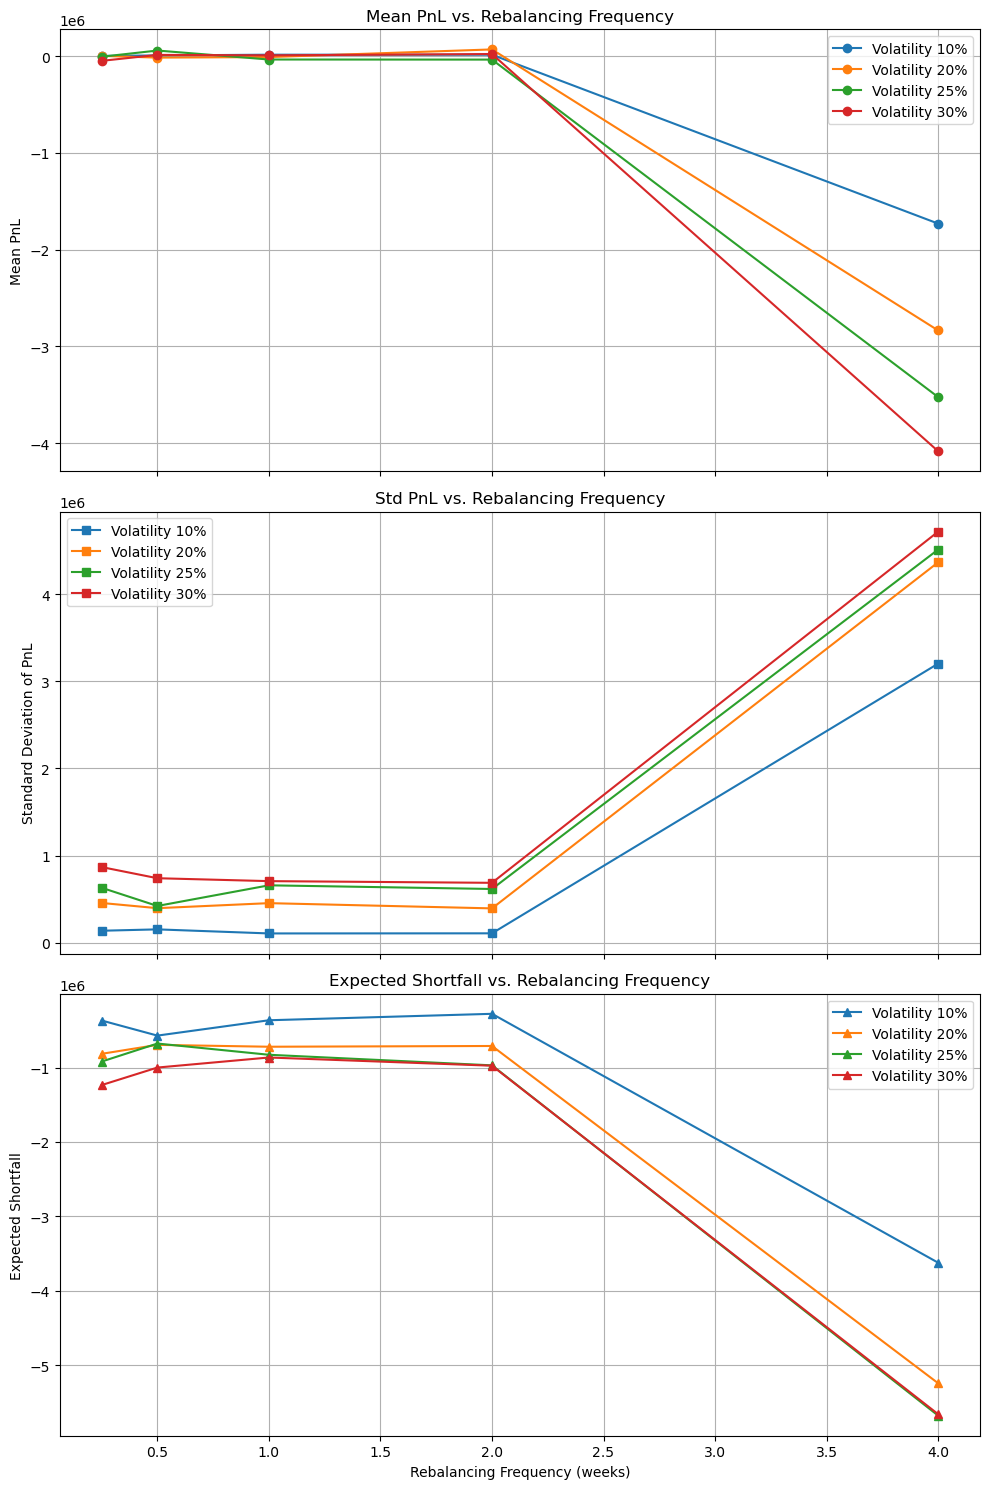

In [7]:
op = "Short Call"
data = [S0,K,r,T,N_options,op]
results_df = get_pnl(data)
visualization(results_df)

## Short Put

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/1119201158.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/4215496269.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: '{:.5f}'.format(x) if isinstance(x, float) else x)


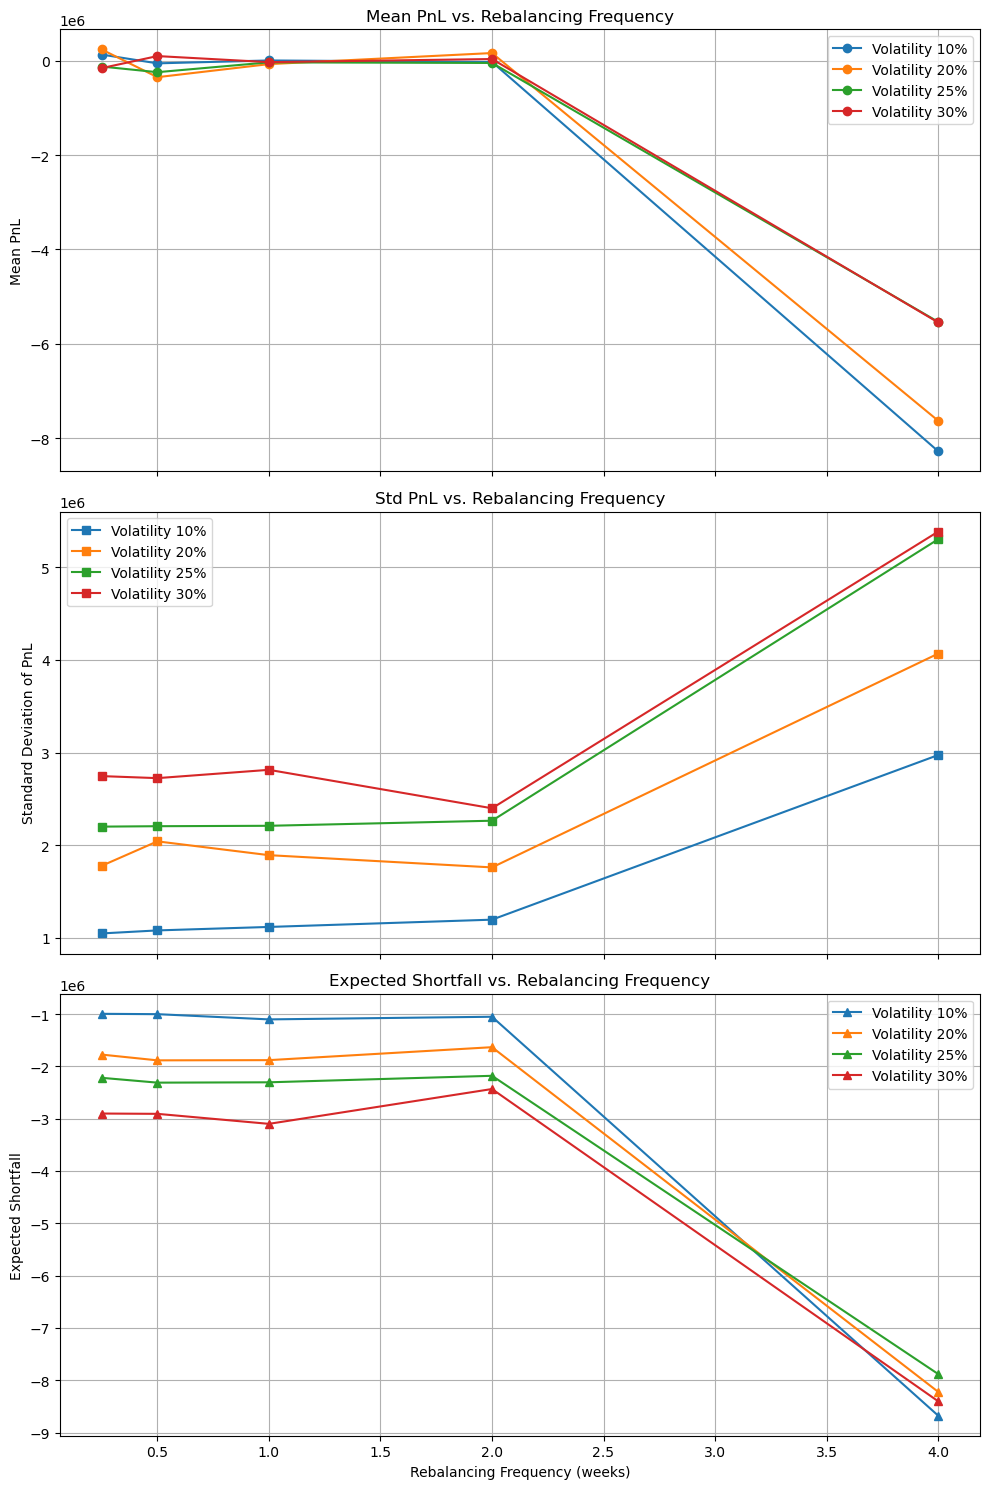

In [8]:
op = "Short Put"
data = [S0,K,r,T,N_options,op]
results_df = get_pnl(data)
visualization(results_df)

## Long Call

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/1119201158.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/4215496269.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: '{:.5f}'.format(x) if isinstance(x, float) else x)


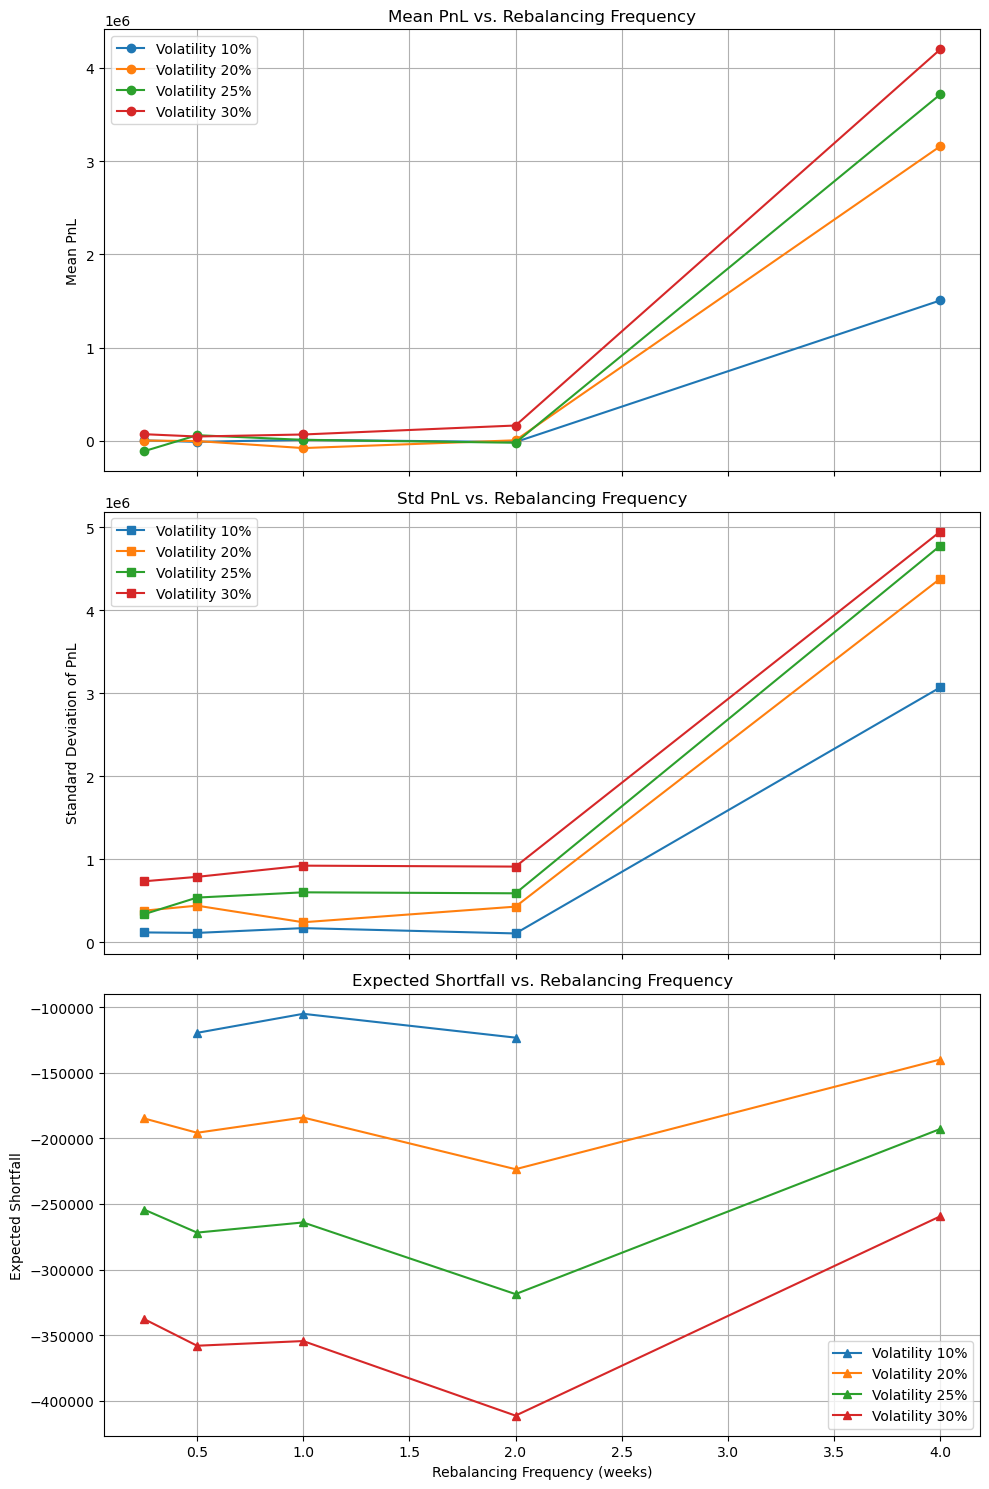

In [9]:
op = "Long Call"
data = [S0,K,r,T,N_options,op]
results_df = get_pnl(data)
visualization(results_df)

## Long Put

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/1119201158.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_73449/4215496269.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: '{:.5f}'.format(x) if isinstance(x, float) else x)


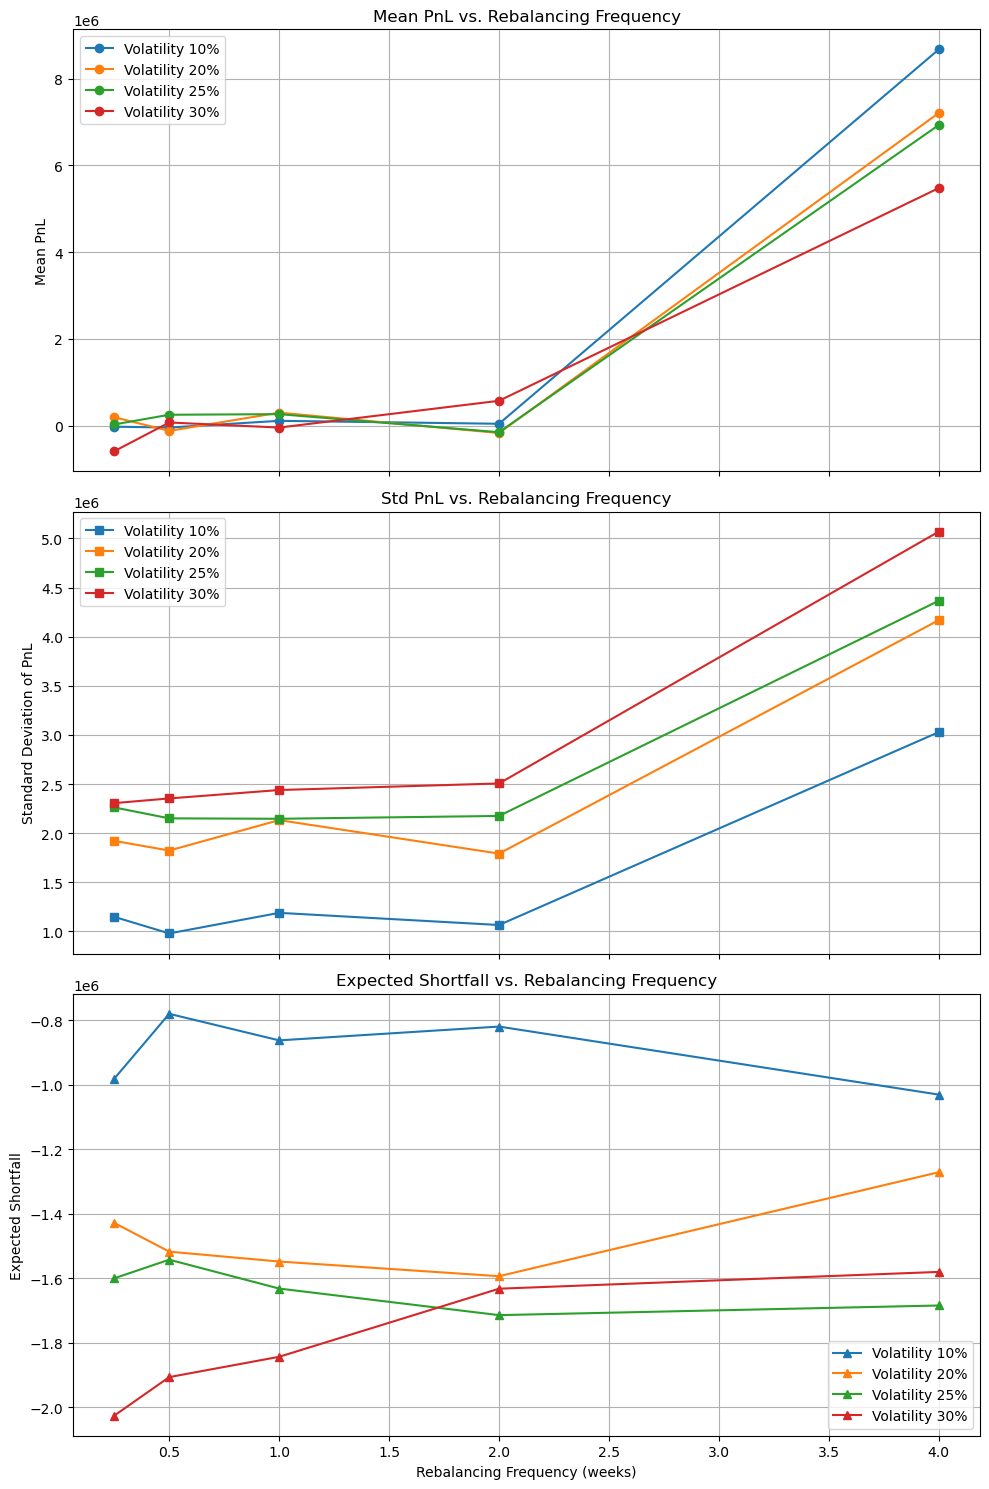

In [10]:
op = "Long Put"
data = [S0,K,r,T,N_options,op]
results_df = get_pnl(data)
visualization(results_df)